# Language Translation
This is the implementation of baseline model

In [1]:
import util
import numpy as np
from sklearn.model_selection import train_test_split

### Preprocess all the data and save it
Make the characters in each sentence into lower case, and add the `<EOS>` tag in the end of each target senquence to indicate the end of a target sentence. In addition, the text would be converted into the corresponding id (one-hot encoding) and saved for the further process.

In [2]:
source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'

util.preprocess_and_save_data(source_path, target_path)

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from tensorflow.python.layers.core import Dense

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoder_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.
- Target sequence length placeholder named "target_sequence_length" with rank 1
- Max target sequence length tensor named "max_target_len" getting its value from applying tf.reduce_max on the target_sequence_length placeholder. Rank 0.
- Source sequence length placeholder named "source_sequence_length" with rank 1

Return the placeholders in the following the tuple (input, targets, learning rate, keep probability, target sequence length, max target sequence length, source sequence length)

In [4]:
def model_inputs():
    """
    Create TF Placeholders for input, targets, learning rate, and lengths of source and target sequences.
    :return: Tuple (input, targets, learning rate, keep probability, target sequence length,
    max target sequence length, source sequence length)
    """

    # placeholder for input sequence data
    inputs = tf.placeholder(tf.int32, shape=[None, None], name="input")
    # placeholder for target sequence data
    targets = tf.placeholder(tf.int32, shape=[None, None], name="target")
    # placeholder for the learning rate of optimization process
    learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
    # placeholder for the keep probability of dropout
    keep_prob = tf.placeholder(tf.float32, shape=[], name="keep_prob")
    # placeholder for lenght of the current target sequences
    target_sequence_length = tf.placeholder(tf.int32, shape=(None,), name="target_sequence_length")
    # the maximum length of the current target sequences
    max_target_len = tf.reduce_max(target_sequence_length, name='max_target_len')   
    # placeholder for lenght of the current target sequences
    source_sequence_length = tf.placeholder(tf.int32, shape=(None,), name="source_sequence_length")
    # a variable for global step
    global_step = tf.Variable(0, name='global_step', trainable=False)
    
    return inputs, targets, learning_rate, keep_prob, target_sequence_length, max_target_len, source_sequence_length, global_step


### Process Decoder Input
Implement `process_decoder_input` by removing the last word id from each batch in `target_data` and concat the GO ID to the begining of each batch.

In [5]:
def process_decoder_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for encoding
    return: Preprocessed target data
    """
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], target_vocab_to_int['<GO>']), ending], 1)
        
    return dec_input

### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer:

In [6]:
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, 
                   source_sequence_length, source_vocab_size, 
                   encoding_embedding_size):
    """
    Create encoding layer using lstm cell
    """
    
    # create the input sequence embedding 
    embed_inputs = tf.contrib.layers.embed_sequence(rnn_inputs, 
                                                   vocab_size=source_vocab_size, 
                                                   embed_dim=encoding_embedding_size)
    
    # build lstm cell with dropout
    def build_lstm(num_units, keep_prob):
        lstm_cell = tf.contrib.rnn.LSTMCell(num_units, 
                                            initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        
        dropout = tf.contrib.rnn.DropoutWrapper(lstm_cell, 
                                                output_keep_prob=keep_prob)
        
        return dropout
    
    # build a multilayer RNN cell
    stacked_lstm = tf.contrib.rnn.MultiRNNCell(
                    [build_lstm(rnn_size, keep_prob) for _ in range(num_layers)])
    
    # build a multilayer RNN
    outputs, final_state = tf.nn.dynamic_rnn(stacked_lstm, 
                                             embed_inputs, 
                                             sequence_length=source_sequence_length, 
                                             dtype=tf.float32)
    
    return outputs, final_state



### Decoding - Training
Create a training decoding layer:

In [7]:

def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                         target_sequence_length, max_summary_length, 
                         output_layer, keep_prob):
    """
    Create a decoding layer for training
    """
    
    helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input, 
                                               sequence_length=target_sequence_length)
    
    decoder = tf.contrib.seq2seq.BasicDecoder(cell=dec_cell, 
                                              helper=helper, 
                                              initial_state=encoder_state,
                                              output_layer=output_layer)
    
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, 
                                                      impute_finished=True,
                                                      maximum_iterations=max_summary_length)
    
    return outputs



### Decoding - Inference
Create inference decoder:

In [8]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id,
                         end_of_sequence_id, max_target_sequence_length,
                         vocab_size, output_layer, batch_size, keep_prob):
    """
    Create a decoding layer for inference
    """

    helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embedding=dec_embeddings, 
                                             start_tokens=tf.fill([batch_size], start_of_sequence_id), 
                                             end_token=end_of_sequence_id)
    
    decoder = tf.contrib.seq2seq.BasicDecoder(cell=dec_cell, 
                                              helper=helper, 
                                              initial_state=encoder_state,
                                              output_layer=output_layer)
    
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, 
                                                impute_finished=True, 
                                                maximum_iterations=max_target_sequence_length)
    return outputs

### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

* Embed the target sequences
* Construct the decoder LSTM cell (just like you constructed the encoder cell above)
* Create an output layer to map the outputs of the decoder to the elements of our vocabulary
* Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, target_sequence_length, max_target_sequence_length, output_layer, keep_prob)` function to get the training logits.
* Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, max_target_sequence_length, vocab_size, output_layer, batch_size, keep_prob)` function to get the inference logits.

Note: You'll need to use [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

In [9]:
def decoding_layer(dec_input, encoder_state,
                   target_sequence_length, max_target_sequence_length,
                   rnn_size,
                   num_layers, target_vocab_to_int, target_vocab_size,
                   batch_size, keep_prob, decoding_embedding_size):
    """
    Create decoding layer
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size], 
                                                   minval=-1, 
                                                   maxval=1))
    
    dec_embed_inputs = tf.nn.embedding_lookup(dec_embeddings, dec_input)

    
    
    def build_lstm(num_units, keep_prob):
        lstm_cell = tf.contrib.rnn.LSTMCell(num_units, 
                                            initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        
        dropout = tf.contrib.rnn.DropoutWrapper(lstm_cell, 
                                                output_keep_prob=keep_prob)
        
        return dropout
    
    stacked_lstm = tf.contrib.rnn.MultiRNNCell(
                    [build_lstm(rnn_size, keep_prob) for _ in range(num_layers)])
    
    output_layer = Dense(target_vocab_size, 
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1),
                         use_bias=False)

    with tf.variable_scope("decoder"):
        train_outputs = decoding_layer_train(encoder_state, stacked_lstm, dec_embed_inputs, 
                                             target_sequence_length, max_target_sequence_length, 
                                             output_layer, keep_prob)
    
    
    with tf.variable_scope("decode", reuse=True):
        infer_outputs = decoding_layer_infer(encoder_state, stacked_lstm, dec_embeddings, target_vocab_to_int['<GO>'],
                                             target_vocab_to_int['<EOS>'], max_target_sequence_length,
                                             target_vocab_size, output_layer, batch_size, keep_prob)
    
    return train_outputs, infer_outputs

### Build the Neural Network
Apply the functions you implemented above to:

- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob,  source_sequence_length, source_vocab_size, encoding_embedding_size)`.
- Process target data using your `process_decoder_input(target_data, target_vocab_to_int, batch_size)` function.
- Decode the encoded input using your `decoding_layer(dec_input, enc_state, target_sequence_length, max_target_sentence_length, rnn_size, num_layers, target_vocab_to_int, target_vocab_size, batch_size, keep_prob, dec_embedding_size)` function.

In [10]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size,
                  source_sequence_length, target_sequence_length,
                  max_target_sentence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size,
                  rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    _, encoder_state = encoding_layer(input_data, rnn_size, num_layers, keep_prob, 
                                       source_sequence_length, source_vocab_size, 
                                       enc_embedding_size)

    dec_input = process_decoder_input(target_data, target_vocab_to_int, batch_size)
    
    train_outputs, infer_outputs = decoding_layer(dec_input, encoder_state,
                                                   target_sequence_length, max_target_sentence_length,
                                                   rnn_size,
                                                   num_layers, target_vocab_to_int, target_vocab_size,
                                                   batch_size, keep_prob, dec_embedding_size)
    
    return train_outputs, infer_outputs

## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability
- Set `display_step` to state how many steps between each debug output statement

In [11]:
# Number of Epochs
epochs = 10
# Batch Size
batch_size = 128
# RNN Size
rnn_size = 64
# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 64
decoding_embedding_size = 64
# Learning Rate
learning_rate = 0.001
# Dropout Keep Probability
keep_probability = 0.8
display_step = 1000

### Build the Graph
Build the graph using the neural network you implemented.

In [12]:
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = util.load_preprocess()
max_target_sentence_length = max([len(sentence) for sentence in target_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob, target_sequence_length, max_target_sequence_length, source_sequence_length, global_step = model_inputs()

    input_shape = tf.shape(input_data)

    train_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                   targets,
                                                   keep_prob,
                                                   batch_size,
                                                   source_sequence_length,
                                                   target_sequence_length,
                                                   max_target_sequence_length,
                                                   len(source_vocab_to_int),
                                                   len(target_vocab_to_int),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   target_vocab_to_int)

    # make a copy of train_logits
    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    # make a copy of inference_logits
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

    # masks are created to facilitate the calculation of the loss.
    # We don't want to calculate the loss for the padding in a sentence.
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping is applied to mitigate the issue of exploding gradients
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients, global_step=global_step)


### Split the data into training, validation, and test data.

In [13]:
# split original data into training and test data 
source_train, source_test, target_train, target_test = train_test_split(source_int_text, 
                                                                        target_int_text, test_size=0.01, random_state=42)

print("The size for test data {},{}".format(len(source_test), len(target_test)))

The size for test data 1379,1379


Batch and pad the source and target sequences

In [14]:
# Split data to training and validation sets
train_source = source_train[batch_size:]
train_target = target_train[batch_size:]
valid_source = source_train[:batch_size]
valid_target = target_train[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(util.get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))

print("The size for training data {},{}".format(len(train_source), len(train_target)))
print("The size for vallidation data {},{}".format(len(valid_source), len(valid_target)))

The size for training data 136354,136354
The size for vallidation data 128,128


### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forms to see if anyone is having the same problem.

In [15]:
loss_list = []
train_acc_list = []
valid_acc_list = []
count = 0

In [16]:
                                                                                             
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                util.get_batches(train_source, train_target, batch_size,
                                source_vocab_to_int['<PAD>'],
                                target_vocab_to_int['<PAD>'])):
            count += 1 
            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 source_sequence_length: sources_lengths,
                 keep_prob: keep_probability})
            
            loss_list.append((count, loss))

            if batch_i % display_step == 0 and batch_i > 0:

                print('Epoch {:>3} Batch {:>4}/{} - Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size,  loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

Epoch   0 Batch 1000/1077 - Loss: 0.8160
Epoch   1 Batch 1000/1077 - Loss: 0.5620
Epoch   2 Batch 1000/1077 - Loss: 0.4408
Epoch   3 Batch 1000/1077 - Loss: 0.3253
Epoch   4 Batch 1000/1077 - Loss: 0.2479
Epoch   5 Batch 1000/1077 - Loss: 0.1898
Epoch   6 Batch 1000/1077 - Loss: 0.1620
Epoch   7 Batch 1000/1077 - Loss: 0.1223
Epoch   8 Batch 1000/1077 - Loss: 0.0955
Epoch   9 Batch 1000/1077 - Loss: 0.0808
Model Trained and Saved


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 

#### Display the training loss 

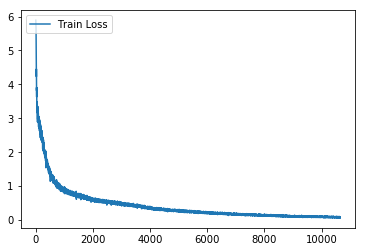

In [18]:
plt.plot(*zip(*loss_list), label="Train Loss")
plt.legend(loc='upper left')
plt.show()

### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [19]:
# Save parameters for checkpoint
util.save_params(save_path)

# Checkpoint

In [20]:
import tensorflow as tf
import numpy as np
import util

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = util.load_preprocess()
load_path = util.load_params()

## Test the trained model
Finally, the trained neural machine translation model is evaluated using the test data.

In [21]:
test_acc_list = []

In [22]:
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    source_sequence_length = loaded_graph.get_tensor_by_name('source_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
    for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                util.get_batches(source_test, target_test, batch_size,
                                source_vocab_to_int['<PAD>'],
                                target_vocab_to_int['<PAD>'])):
        
        test_logits = sess.run(logits, {input_data: source_batch,
                               target_sequence_length: sources_lengths,
                               source_sequence_length: targets_lengths,
                               keep_prob: 1.0})
        
        print('Input')
        print('  Word Ids:      {}'.format([i for i in source_batch[0]]))
        print('  English Words: {}'.format(" ".join([source_int_to_vocab[i] for i in source_batch[0] 
                                           if i not in [0, 1]])))

        print('\nPrediction')
        print('  Word Ids:      {}'.format([i for i in test_logits[0]]))
        print('  French Words: {}'.format(" ".join([target_int_to_vocab[i] for i in test_logits[0] 
                                                   if i not in [0, 1]])))
        
        print('\nTarget')
        print('  Word Ids:      {}'.format([i for i in target_batch[0]]))
        print('  French Words: {}'.format(" ".join([target_int_to_vocab[i] for i in target_batch[0]
                                                  if i not in [0, 1]])))
        print("\n------------------------------------------------------------------\n")
        
        test_acc = util.get_bleu(target_batch, test_logits)
        test_acc_list.append(test_acc)

INFO:tensorflow:Restoring parameters from checkpoints/dev
Input
  Word Ids:      [127, 116, 218, 174, 59, 20, 99, 154, 23, 116, 218, 187, 223, 221, 216, 0, 0]
  English Words: california is sometimes dry during may , and it is sometimes wonderful in february .

Prediction
  Word Ids:      [78, 328, 253, 121, 173, 161, 141, 128, 315, 157, 14, 328, 253, 219, 38, 210, 170]
  French Words: californie est parfois sec au mois de mai , et il est parfois merveilleux en février .

Target
  Word Ids:      [78, 328, 253, 121, 173, 161, 141, 128, 315, 157, 14, 328, 253, 219, 38, 210, 170, 1, 0, 0, 0]
  French Words: californie est parfois sec au mois de mai , et il est parfois merveilleux en février .

------------------------------------------------------------------

Input
  Word Ids:      [14, 116, 218, 184, 59, 183, 99, 154, 23, 116, 173, 181, 223, 103, 216, 0, 0]
  English Words: paris is sometimes beautiful during summer , and it is usually snowy in fall .

Prediction
  Word Ids:      [10, 3

In [23]:
print("The BLEU score for the test data is {}".format(np.mean(test_acc_list)))

The BLEU score for the test data is 0.797999510477571
